(960, 1280, 3)


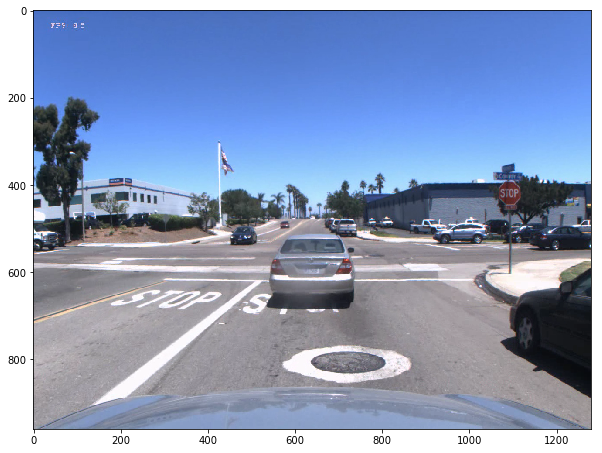

In [7]:
import cv2
import matplotlib.pyplot as plt
from utils.image_handler import preprocess_img
%matplotlib inline

# img = cv2.cvtColor(cv2.imread('person.jpg'), cv2.COLOR_BGR2RGB)

img = cv2.cvtColor(cv2.imread('./test_images/stop_1405106680.avi_image9.png'), cv2.COLOR_BGR2RGB)

# img = cv2.resize(img, (608, 448))
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(img.shape)

In [8]:
import numpy as np
import cv2

# dog    = Box(70, 258, 209, 356, 'Dog', 0.79)
# person = Box(190, 98, 271, 379, 'Person', 0.81)
# horse  = Box(399, 128, 605, 352, 'Horse', 0.89)
# boxes = [dog, person, horse]
class Box():
    def __init__(self, x1, y1, x2, y2, label, score):
        self.x1 = int(x1)
        self.x2 = int(x2)
        self.y1 = int(y1)
        self.y2 = int(y2)
        self.cls = str(label)
        self.score = float(score)

        
def draw(img, boxes, color=[0, 255, 0], thickness=3):
    result = np.copy(img)
    
    for box in boxes:
        p1 = (box.x1, box.y1)
        p2 = (box.x2, box.y2)
        result = cv2.rectangle(result, p1, p2, color=(0, 255, 0), thickness=thickness)
        
    return result

In [9]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from cfg import *
from model.yolov2 import YOLOv2, darknet19

THRESHOLD = 0.7
N_CLASSES = 80
ANCHORS   = np.array(((0.57273, 0.677385), (1.87446, 2.06253), 
                      (3.33843, 5.47434), (7.88282, 3.52778), (9.77052, 9.16828)))

# K.clear_session()
# yolov2 = YOLOv2(feature_extractor=darknet19(input_size=(960, 1280, 3)), num_anchors=N_ANCHORS, num_classes=N_CLASSES)
# model  = yolov2.model
# model.load_weights('../yolo-coco.h5')

# # print(model.layers[1].get_weights())
model = load_model('../yolo-coco.h5')
# model.summary()
# print(model.layers[1].get_weights())

/home/ubuntu/anaconda2/envs/yad2k/lib/python3.6/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
# Preprocess input
input_img = img / 255. 
input_img = cv2.resize(input_img, (608, 608))
input_img = np.expand_dims(input_img, 0)

# Making prediction
netout = model.predict(input_img)

netshape = np.shape(netout)
netout = np.reshape(netout, [-1, netshape[1], netshape[2], 5, N_CLASSES+5])

GRID_H, GRID_W = netout.shape[1:3]
height, width ,c  = img.shape
print(np.shape(netout))

(1, 19, 19, 5, 85)


In [11]:
N_ANCHORS = 5
image_shape = img.shape

# Create GRID-cell map
cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
cx = K.tile(cx, [GRID_H])
cx = K.reshape(cx, [-1, GRID_H, GRID_W, 1])

cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
cy = K.reshape(cy, [-1, 1])
cy = K.tile(cy, [1, GRID_W])  
cy = K.reshape(cy, [-1])    
cy = K.reshape(cy, [-1, GRID_H, GRID_W, 1])

c_xy = tf.stack([cx, cy], -1)
c_xy = K.cast(c_xy, K.dtype(netout))


anchors_tensor = tf.cast(K.reshape(K.variable(ANCHORS), [1, 1, 1, 5, 2]), tf.float32)
netout_size   = K.cast(K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2]), K.dtype(netout))

box_xy          = K.sigmoid(netout[..., :2])
box_wh          = K.exp(netout[..., 2:4])
box_confidence  = K.sigmoid(netout[..., 4:5])
box_class_probs = K.softmax(netout[..., 5:])

# Adjust predictions to each spatial grid point and anchor size.
box_xy = (box_xy + c_xy) / netout_size
box_wh = box_wh * anchors_tensor / netout_size
box_mins  = box_xy - (box_wh / 2.)
box_maxes = box_xy + (box_wh / 2.)

# Y1, X1, Y2, X2
boxes   = K.concatenate([box_mins[..., 1:2], box_mins[..., 0:1],  box_maxes[..., 1:2], box_maxes[..., 0:1]])

box_scores       = box_confidence * box_class_probs
box_classes      = K.argmax(box_scores, -1)
box_class_scores = K.max(box_scores, -1)
prediction_mask  = (box_class_scores >= 0.7)

boxes   = tf.boolean_mask(boxes, prediction_mask)
scores  = tf.boolean_mask(box_class_scores, prediction_mask)
classes = tf.boolean_mask(box_classes, prediction_mask)

# Scale boxes back to original image shape.
height = image_shape[0]
width = image_shape[1]

image_dims = tf.cast(K.stack([height, width, height, width]), tf.float32)
image_dims = K.reshape(image_dims, [1, 4])
boxes = boxes * image_dims


# nms_index = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes_tensor, iou_threshold=0.5)

# # TODO: Something must be done about this ugly hack!
max_boxes_tensor = K.variable(10, dtype='int32')
K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
nms_index = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=0.5)
boxes = K.gather(boxes, nms_index)
scores = K.gather(scores, nms_index)
classes = K.gather(classes, nms_index)


with tf.Session() as sess:   
    tf.global_variables_initializer().run()
    boxes = boxes.eval()
    scores = scores.eval()
    classes = classes.eval()

print(boxes, scores, classes)

[[  499.62176514   542.85998535   670.09967041   749.1362915 ]
 [  484.38760376   921.07202148   536.51568604  1052.23718262]] [ 0.84231639  0.75936013] [2 2]


In [14]:
result = boxes

bboxes = []
for box, score, cls in zip(result, scores, classes):
    y1, x1, y2, x2 = box.astype(np.int)
    bboxes.append(Box(x1, y1, x2, y2, cls, score))

result = draw(img, bboxes)
plt.figure(figsize=(15, 15))

plt.imshow(result)
print(img.shape)

(960, 1280, 3)


In [ ]:
def yolo_head(feats, anchors, num_classes):

    num_anchors = len(anchors)
    conv_dims = K.shape(feats)[1:3]
    GRID_W = conv_dims[1]
    GRID_H = conv_dims[0]
    # Reshape to batch, height, width, num_anchors, box_params.
    cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
    cx = K.tile(cx, [GRID_H])
    cx = K.reshape(cx, [-1, GRID_H, GRID_W, 1])

    cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
    cy = K.reshape(cy, [-1, 1])
    cy = K.tile(cy, [1, GRID_W])  
    cy = K.reshape(cy, [-1])    
    cy = K.reshape(cy, [-1, GRID_H, GRID_W, 1])

    cxy = tf.stack([cx, cy], -1)
    c_xy = K.cast(cxy, K.dtype(netout))

    anchors_tensor = tf.cast(K.reshape(K.variable(ANCHORS), [1, 1, 1, 5, 2]), tf.float32)
    netout_size   = K.cast(K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2]), K.dtype(netout))

    feats      = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims  = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy          = K.sigmoid(feats[..., :2])
    box_wh          = K.exp(feats[..., 2:4])
    box_confidence  = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust predictions to each spatial grid point and anchor size.
    box_xy = (box_xy + c_xy) / netout_size
    box_wh = box_wh * anchors_tensor / netout_size
    return box_xy, box_wh, box_confidence, box_class_probs


def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins  = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)
    return K.concatenate([box_mins[..., 1:2], box_mins[..., 0:1], 
                          box_maxes[..., 1:2], box_maxes[..., 0:1]])

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    return boxes, scores, classes


def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        boxes, box_confidence, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.cast(K.stack([height, width, height, width]), tf.float32)
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    
    return boxes, scores, classes


yolo_outputs           = yolo_head(netout, ANCHORS, N_CLASSES)
boxes, scores, classes = yolo_eval(yolo_outputs, img.shape, max_boxes=10, score_threshold=0.6, iou_threshold=0.5)

input_image_shape      = K.placeholder(shape=(2, ))
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            model.input: input_img,
            input_image_shape: [ 416, 416],
            K.learning_phase(): 0
        })
    print('Found {} boxes for {}'.format(len(out_boxes), 'person'))
    
boxes = []
for box, score, cls in zip(out_boxes, out_scores, out_classes):
    y1, x1, y2, x2 = box.astype(np.int)
    boxes.append(Box(x1, y1, x2, y2, cls, score))

result = draw(img, boxes)
plt.imshow(result)
print(img.shape)

In [ ]:


# Plot result
plt.figure(figsize=(15, 15))
plt.imshow(result)